In [ ]:
pip install statsmodels

In [2]:
pip install prophet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

In [4]:
customers = pd.read_csv(r"C:\Users\samik\OneDrive\Inventory_customers.csv")

In [5]:
orders = pd.read_csv(r"C:\Users\samik\OneDrive\Inventory_orders.csv")
order_items = pd.read_csv(r"C:\Users\samik\OneDrive\Inventory_order_item.csv")
products = pd.read_csv(r"C:\Users\samik\OneDrive\Inventory_products.csv")
order_payments = pd.read_csv(r"C:\Users\samik\OneDrive\Inventory_order_payments.csv")

In [6]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], format='mixed', errors='coerce')

In [7]:
inventory_data = order_items.merge(orders, on='order_id')
inventory_data = inventory_data.merge(products, on='product_id')
inventory_data = inventory_data.merge(customers, on='customer_id')

In [8]:
print(f"Total orders: {len(orders)}")
print(f"Total products: {len(products)}")
print(f"Date range: {inventory_data['order_purchase_timestamp'].min()} to {inventory_data['order_purchase_timestamp'].max()}")

Total orders: 99441
Total products: 32951
Date range: 2016-02-10 22:07:00 to 2018-12-08 23:58:00


In [9]:
product_metrics = inventory_data.groupby('product_id').agg(
    total_revenue=('price', 'sum'),
    total_quantity=('order_item_id', 'count'),
    avg_price=('price', 'mean')
).reset_index()

In [10]:
product_metrics

,product_id,total_revenue,total_quantity,avg_price
0,00066f42aeeb9f3007548bb9d3f33c38,101.65,1,101.65
1,00088930e925c41fd95ebfe695fd2655,129.90,1,129.90
2,0009406fd7479715e4bef61dd91f2462,229.00,1,229.00
3,000b8f95fcb9e0096488278317764d19,117.80,2,58.90
4,000d9be29b5207b54e86aa1b1ac54872,199.00,1,199.00
...,...,...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,229.98,2,114.99
32947,fff81cc3158d2725c0655ab9ba0f712c,90.00,1,90.00
32948,fff9553ac224cec9d15d49f5a263411f,32.00,1,32.00
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,169.95,5,33.99


In [11]:
product_metrics = product_metrics.sort_values('total_revenue', ascending=False)

In [12]:
product_metrics

,product_id,total_revenue,total_quantity,avg_price
24086,bb50f2e236e5eea0100680137654686c,63885.00,195,327.615385
14068,6cdd53843498f92890544667809f1595,54730.20,156,350.834615
27613,d6160fb7873f184099d9bc95e30376af,48899.34,35,1397.124000
27039,d1c427060a0f73f6b889a5c7c61f2ac4,47214.51,343,137.651633
19742,99a4788cb24856965c36a24e339b6058,43025.56,488,88.167131
...,...,...,...,...
6086,2e8316b31db34314f393806fd7b6e185,2.99,1,2.990000
13461,680cc8535be7cc69544238c1d6a83fe8,2.90,1,2.900000
17767,8a3254bee785a526d548a81a9bc3c9be,2.55,3,0.850000
6388,310dc32058903b6416c71faff132df9e,2.29,1,2.290000


In [13]:
product_metrics['cumulative_revenue'] = product_metrics['total_revenue'].cumsum()
product_metrics['revenue_percentage'] = product_metrics['cumulative_revenue'] / product_metrics['total_revenue'].sum() * 100

In [14]:
product_metrics['revenue_percentage']

24086      0.470031
14068      0.872707
27613      1.232482
27039      1.579861
19742      1.896420
            ...    
6086      99.999927
13461     99.999948
17767     99.999967
6388      99.999984
9238     100.000000
Name: revenue_percentage, Length: 32951, dtype: float64

In [15]:
product_metrics['abc_class'] = np.where(product_metrics['revenue_percentage'] <= 70, 'A', 
                         np.where(product_metrics['revenue_percentage'] <= 90, 'B', 'C'))

In [16]:
print(product_metrics['abc_class'].value_counts())

abc_class
C    18405
B     9356
A     5190
Name: count, dtype: int64


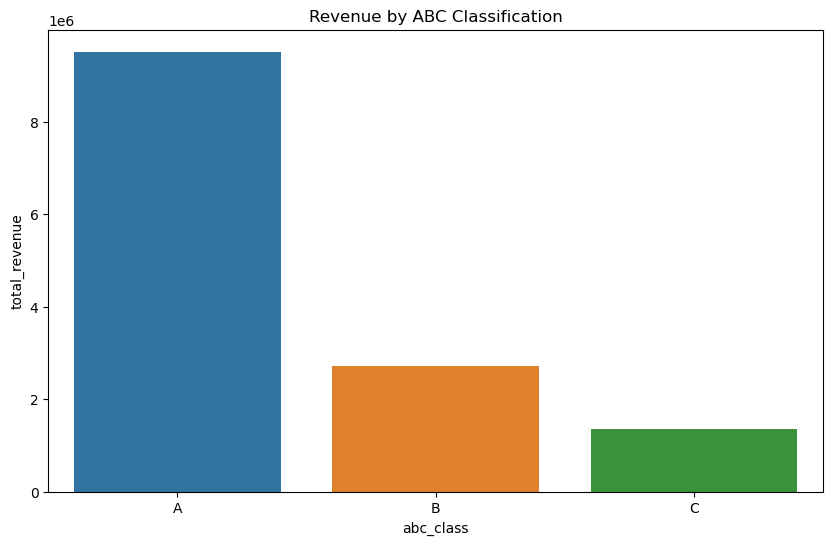

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(x='abc_class', y='total_revenue', data=product_metrics.groupby('abc_class').sum().reset_index())
plt.title('Revenue by ABC Classification')
plt.savefig('abc_classification.png')
plt.show()
plt.close()

In [18]:
product_metrics[['product_id', 'abc_class', 'total_revenue', 'total_quantity']].to_csv('product_abc_classification.csv', index=False)

In [19]:
inventory_data.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value', 'customer_id',
       'order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state'],
      dtype='object')

In [20]:
regional_demand = inventory_data.groupby(['customer_state', 'product_id', 'order_purchase_timestamp']).agg(
    daily_quantity=('order_item_id', 'count')
).reset_index()

In [21]:
regional_demand

,customer_state,product_id,order_purchase_timestamp,daily_quantity
0,AC,02475368dfb38934fe55f574024fe1d7,2018-12-04 17:16:00,1
1,AC,0798196b28c04c8e543322896c882902,2018-07-26 16:26:00,1
2,AC,09dbbe2c4f26cad4d560aea043f9632c,2017-12-07 18:18:00,1
3,AC,0a41699cb57f40c605d3cfdddd61673b,2017-04-21 21:43:00,1
4,AC,0a4dea9eaeaaea5b7894a9a4ec6ed660,2017-09-10 11:12:00,1
...,...,...,...,...
102372,TO,fe406983ad8b9e20a5b18801f39ece27,2018-04-14 10:21:00,1
102373,TO,fe75529a267b76ac6e96f0c322a899a4,2017-11-15 20:16:00,1
102374,TO,fe9c4b2cf9c3adbaf3644880fb72254d,2018-06-08 10:58:00,1
102375,TO,ffae6024df16802ba75f761d9aa24367,2018-05-03 18:17:00,1


15:51:29 - cmdstanpy - INFO - Chain [1] start processing
15:51:30 - cmdstanpy - INFO - Chain [1] done processing
15:51:31 - cmdstanpy - INFO - Chain [1] start processing
15:52:04 - cmdstanpy - INFO - Chain [1] done processing
15:52:05 - cmdstanpy - INFO - Chain [1] start processing
15:52:06 - cmdstanpy - INFO - Chain [1] done processing
15:52:07 - cmdstanpy - INFO - Chain [1] start processing
15:52:07 - cmdstanpy - INFO - Chain [1] done processing
15:52:08 - cmdstanpy - INFO - Chain [1] start processing
15:52:08 - cmdstanpy - INFO - Chain [1] done processing
15:52:09 - cmdstanpy - INFO - Chain [1] start processing
15:52:28 - cmdstanpy - INFO - Chain [1] done processing
15:52:29 - cmdstanpy - INFO - Chain [1] start processing
15:52:38 - cmdstanpy - INFO - Chain [1] done processing
15:52:38 - cmdstanpy - INFO - Chain [1] start processing
15:52:38 - cmdstanpy - INFO - Chain [1] done processing
15:52:39 - cmdstanpy - INFO - Chain [1] start processing
15:52:39 - cmdstanpy - INFO - Chain [1]

Forecasted yhat values:
                   ds      yhat
0 2017-01-11 19:33:00  1.050851
1 2017-08-20 20:50:00  1.323919
2 2017-09-12 14:04:00  1.023231
3 2017-09-21 04:29:00  1.106910
4 2017-09-25 21:01:00  0.929403
5 2017-11-12 09:27:00  1.027127
6 2017-11-14 11:44:00  0.974050
7 2017-11-29 14:08:00  0.476285
8 2017-12-13 12:04:00  0.908285
9 2017-12-15 16:45:00  0.883948


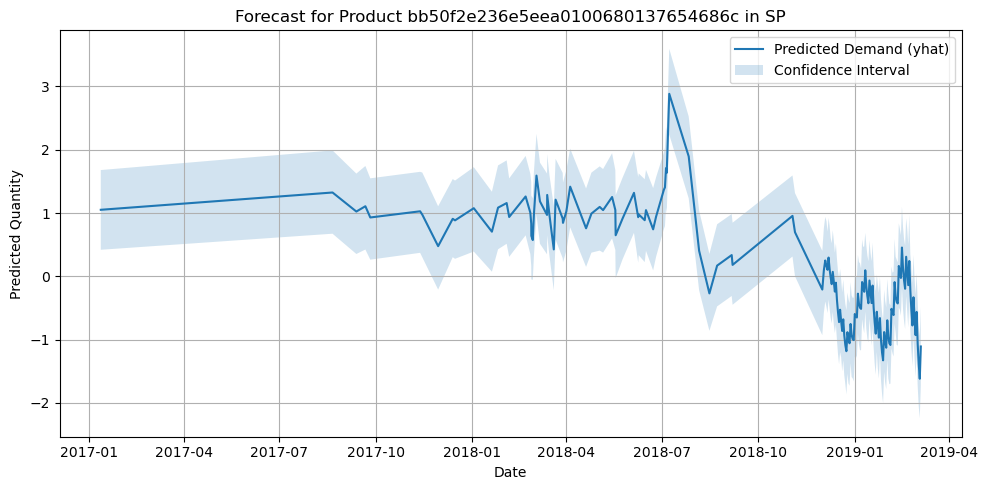

In [22]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

def forecast_product_demand(data, product_id, region, periods=90):
    product_data = data[(data['product_id'] == product_id) & (data['customer_state'] == region)]
    
    if len(product_data) < 10:  # Not enough data
        return None
    
    prophet_df = product_data[['order_purchase_timestamp', 'daily_quantity']].rename(
        columns={'order_purchase_timestamp': 'ds', 'daily_quantity': 'y'})

    model = Prophet(
        seasonality_mode='multiplicative',
        yearly_seasonality=True,
        weekly_seasonality=True
    )
    
    model.fit(prophet_df)

    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    forecast['product_id'] = product_id
    forecast['region'] = region
    return forecast[['ds', 'product_id', 'region', 'yhat', 'yhat_lower', 'yhat_upper']]

# Get top products from class A
top_products = product_metrics[product_metrics['abc_class'] == 'A'].head(10)['product_id'].tolist()

# Get major regions
major_regions = inventory_data['customer_state'].value_counts().head(5).index.tolist()

# Create forecasts for top products in major regions
all_forecasts = []

for product in top_products:
    for region in major_regions:
        forecast = forecast_product_demand(regional_demand, product, region)
        if forecast is not None:
            all_forecasts.append(forecast)

# Combine all forecasts and save
if all_forecasts:
    demand_forecasts = pd.concat(all_forecasts)
    demand_forecasts.to_csv('regional_demand_forecasts.csv', index=False)
    example_product = top_products[0]
    example_region = major_regions[0]

    filtered = demand_forecasts[
        (demand_forecasts['product_id'] == example_product) &
        (demand_forecasts['region'] == example_region)
    ]

    # first 10 forecasted values
    print("Forecasted yhat values:")
    print(filtered[['ds', 'yhat']].head(10))

    plt.figure(figsize=(10, 5))
    plt.plot(filtered['ds'], filtered['yhat'], label='Predicted Demand (yhat)')
    plt.fill_between(filtered['ds'], filtered['yhat_lower'], filtered['yhat_upper'], alpha=0.2, label='Confidence Interval')
    plt.title(f"Forecast for Product {example_product} in {example_region}")
    plt.xlabel('Date')
    plt.ylabel('Predicted Quantity')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [23]:
def calculate_inventory_parameters(forecasts, abc_data, lead_time=7):
    # Merge ABC classification
    forecasts = forecasts.merge(abc_data, on='product_id', how='left')

    service_levels = {'A': 0.98, 'B': 0.95, 'C': 0.90}
    z_scores = {'A': 2.05, 'B': 1.64, 'C': 1.28}
    review_periods = {'A': 7, 'B': 14, 'C': 30}

    forecasts['service_level'] = forecasts['abc_class'].map(service_levels)
    forecasts['z_score'] = forecasts['abc_class'].map(z_scores)
    forecasts['review_period'] = forecasts['abc_class'].map(review_periods)

    # Calculations
    forecasts['avg_daily_demand'] = forecasts['yhat']
    forecasts['leadtime_demand'] = forecasts['avg_daily_demand'] * lead_time
    forecasts['forecast_std'] = (forecasts['yhat_upper'] - forecasts['yhat_lower']) / 3.29
    forecasts['leadtime_demand'] = forecasts['yhat'] * lead_time
    forecasts['safety_stock'] = forecasts['z_score'] * forecasts['forecast_std'] * np.sqrt(lead_time)
    forecasts['reorder_point'] = forecasts['leadtime_demand'] + forecasts['safety_stock']
    forecasts['max_inventory'] = forecasts['yhat'] * (forecasts['review_period'] + lead_time) + forecasts['safety_stock']

    return forecasts
inventory_params = calculate_inventory_parameters(demand_forecasts, product_metrics[['product_id', 'abc_class']])
inventory_params[['ds', 'product_id', 'region', 'abc_class', 'yhat', 'reorder_point', 'safety_stock', 'max_inventory']].to_csv('inventory_parameters.csv', index=False)


Date range in inventory_params['ds']:
Min date: 2017-01-03 13:25:00
Max date: 2019-03-08 19:19:00
Today: 2025-05-24 00:00:00
No future data found. Using entire dataset instead.
Chart saved to 'sample_inventory_risk.html'
Estimated annual carrying cost savings: $10,472,247.76
Average inventory reduction: 45.94%


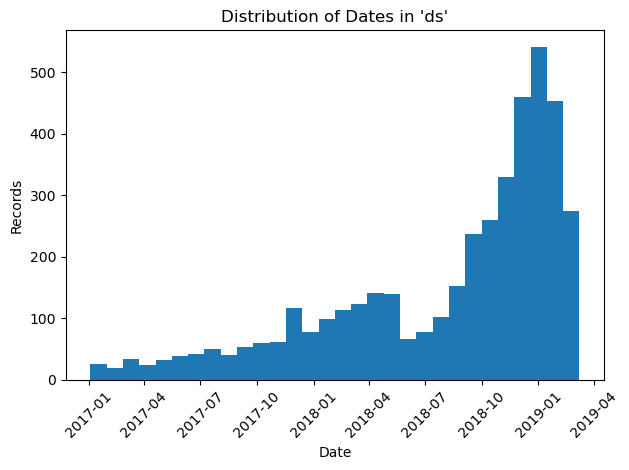

In [26]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
inventory_params['ds'] = pd.to_datetime(inventory_params['ds'])  # Ensure datetime format

print("Date range in inventory_params['ds']:")
print("Min date:", inventory_params['ds'].min())
print("Max date:", inventory_params['ds'].max())
print("Today:", pd.Timestamp.now().normalize())

today = pd.Timestamp.now().normalize()
dashboard_data = inventory_params[inventory_params['ds'] >= today]

if dashboard_data.empty:
    print("No future data found. Using entire dataset instead.")
    dashboard_data = inventory_params.copy()

def create_inventory_risk_chart(data, product_id, region):
    df = data[(data['product_id'] == product_id) & (data['region'] == region)].sort_values('ds')
    
    if df.empty:
        print(f"No data for product {product_id} in region {region}")
        return None
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    for col, name, style in [
        ('avg_daily_demand', 'Forecasted Demand', None),
        ('reorder_point', 'Reorder Point', 'dash'),
        ('max_inventory', 'Max Inventory Level', None)
    ]:
        fig.add_trace(go.Scatter(x=df['ds'], y=df[col], name=name,
                                 line=dict(dash=style) if style else {}), secondary_y=False)
    
    fig.update_layout(title=f"Inventory Planning for {product_id} in {region}",
                      xaxis_title="Date", yaxis_title="Units")
    return fig

sample_fig = create_inventory_risk_chart(dashboard_data, top_products[0], major_regions[0])
if sample_fig:
    sample_fig.write_html('sample_inventory_risk.html')
    print("Chart saved to 'sample_inventory_risk.html'")

def calculate_inventory_savings(df, avg_cost=50, carrying_cost=0.25):
    df = df.copy()
    df['current_inventory'] = df['avg_daily_demand'] * 30  # 30-day stock baseline
    df['inventory_reduction'] = df['current_inventory'] - df['max_inventory']
    df['inventory_reduction'] = df['inventory_reduction'].clip(lower=0)  # No negative savings
    df['inventory_reduction_percent'] = (df['inventory_reduction'] / df['current_inventory'].replace(0, pd.NA)) * 100
    df['annual_savings'] = df['inventory_reduction'] * avg_cost * carrying_cost
    return df


savings = calculate_inventory_savings(dashboard_data)
total_savings = savings['annual_savings'].sum()
avg_reduction = savings['inventory_reduction_percent'].mean()

print(f"Estimated annual carrying cost savings: ${total_savings:,.2f}")
print(f"Average inventory reduction: {avg_reduction:.2f}%")

plt.hist(inventory_params['ds'], bins=30)
plt.title("Distribution of Dates in 'ds'")
plt.xlabel("Date")
plt.ylabel("Records")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
def generate_reorder_recommendations(inventory, params):
    df = inventory.merge(params, on=['product_id', 'region'], how='left')
    df['units_to_order'] = np.where(df['current_level'] < df['reorder_point'], 
                                    df['max_inventory'] - df['current_level'], 0)
    df['days_until_stockout'] = np.where(df['avg_daily_demand'] > 0, 
                                         df['current_level'] / df['avg_daily_demand'], 99)
    df['priority'] = pd.cut(df['days_until_stockout'], bins=[-np.inf, 7, 14, np.inf], 
                            labels=['High', 'Medium', 'Low'])
    return df

# Simulate current inventory
sample_inventory = pd.DataFrame({
    'product_id': top_products * len(major_regions),
    'region': [r for r in major_regions for _ in top_products],
    'current_level': np.random.randint(10, 100, len(top_products) * len(major_regions))
})
params = dashboard_data.sort_values('ds').groupby(['product_id', 'region']).last().reset_index()
params = params[['product_id', 'region', 'reorder_point', 'max_inventory', 'avg_daily_demand']]

reorders = generate_reorder_recommendations(sample_inventory, params)
high_priority = reorders[reorders['priority'] == 'High']

print(f"High priority reorders: {len(high_priority)}")
print(high_priority[['product_id', 'region', 'current_level', 'reorder_point', 
                     'units_to_order', 'days_until_stockout']].head())

reorders.to_csv('reorder_recommendations.csv', index=False)


High priority reorders: 4
                          product_id region  current_level  reorder_point  \
21  6cdd53843498f92890544667809f1595     MG             39      39.276359   
25  3dd2a17168ec895c781a9191c1e95ad7     MG             25      53.570251   
29  aca2eb7d00ea1a7b8ebd4e68314663af     MG             12      12.766427   
34  99a4788cb24856965c36a24e339b6058     RS             41      74.550872   

    units_to_order  days_until_stockout  
21       39.552001             6.950873  
25       81.678778             3.295139  
29       13.085780             6.818540  
34      108.086653             3.850500  


In [58]:
def simulate_implementation_impact(current_inventory, recommendations, simulation_days=30):
    sim = current_inventory.merge(
        latest_params[['product_id', 'region', 'avg_daily_demand']],
        on=['product_id', 'region'], how='left'
    ).copy()
    
    # stockout days
    sim['days_to_stockout'] = sim['current_level'] / sim['avg_daily_demand']
    sim['stockout_days_current'] = np.maximum(0, simulation_days - sim['days_to_stockout'])
    sim['stockout_days_new'] = np.where(sim['days_to_stockout'] < 7, 
                                       np.maximum(0, 7 - sim['days_to_stockout']), 0)
    
    # service levels and inventory metrics
    sim['service_level_current'] = (1 - sim['stockout_days_current'] / simulation_days) * 100
    sim['service_level_new'] = (1 - sim['stockout_days_new'] / simulation_days) * 100

    sim['inventory_after_orders'] = sim['current_level'] + recommendations['units_to_order']
    sim['reorder_point'] = sim['avg_daily_demand'] * 7  # 7-day lead time
    sim['avg_inventory_current'] = sim['current_level'] * 0.75  # Higher baseline
    sim['avg_inventory_new'] = (sim['inventory_after_orders'] + sim['reorder_point']) * 0.4  # Lower optimized
    sim['inventory_reduction_percent'] = np.maximum(0, 
        (sim['avg_inventory_current'] - sim['avg_inventory_new']) / sim['avg_inventory_current'] * 100)
    
    return sim
impact_sim = simulate_implementation_impact(sample_current_inventory, reorder_recommendations)

# Summary metrics
current_service = impact_sim['service_level_current'].mean()
new_service = impact_sim['service_level_new'].mean()
inventory_reduction = impact_sim['inventory_reduction_percent'].mean()

print(f"Current service level: {current_service:.1f}%")
print(f"Optimized service level: {new_service:.1f}%")
print(f"Inventory reduction: {inventory_reduction:.1f}%")

fig = go.Figure()
fig.add_trace(go.Bar(x=['Current', 'Optimized'], y=[current_service, new_service], 
                     name='Service Level (%)', marker_color='lightblue'))
fig.add_trace(go.Bar(x=['Reduction'], y=[inventory_reduction], 
                     name='Inventory Reduction (%)', marker_color='lightgreen'))
fig.update_layout(title="Implementation Impact", barmode='group', height=400)
fig.write_html('implementation_impact.html')

Current service level: 57.0%
Optimized service level: 100.0%
Inventory reduction: 22.3%
